# Lidar ToF-Abstandsmessung indirekt über die Phase
Version 4.2.2019, S. Mack

Eine preiswerte und sehr genaue Messtechnik für die Lichtlaufzeitmessung ist die Phasenmessung. Dabei wird als Sender ein Dauerstrichlaser (CW-Laser) verwendet, dessen Licht intensitätsmoduliert ist. Das "Lichtecho" ist dann ebenfalls mit der gleichen Frequenz phasenmoduliert. Je nach Abstand (=Reichweite), d.h. *Lichtlaufzeit* hat das Echolicht bezüglich seiner Intensitätsmodulation einen Phasenversatz im Vergleich zum gerade emitierten Sendelicht.  

**Hierbei ist es wichtig, dass es nicht um einen Phasenversatz der elektromagnetischen Welle sondern um einen Phasenversatz der *Intensitätsmodulation* handelt.** Im Gegensatz zu Radar ist Lidar üblicherweise eine inkokärente Messtechnik: Die Welleneigenschaft des Lichts spielt keine Rolle. Eine Photodiode misst anders als eine Antenne nur die Intenität, nicht die Feldstärke!  

Im nachfolgendem Text wird dargestellt, wie durch Mischen des Intensitätssignals des Sendelichts mit dem des Echolichts der Phasenversatz und damit die Lichtlaufzeit bzw. der Messabstand bestimmt wird. Weiter wird gezeigt, wie man mit zwei unterschiedlichen Modulationsfrequenzen den Eindeutigkeitsbereich wesentlich vergrößern kann.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# special %-command for Jupyter notebooks to render plots inside notebook
%matplotlib inline

## Technische Möglichkeiten zur Modulation von Laserlicht
Licht lässt sich prinzipiell mit sogenannten mechanischen Shuttern modulieren. In einem analogen Filmprojektor waren vor Urzeiten z.B. solche Schutter enthalten. Synchron zur Bildrate öffneten sie kurz eine optische Blende, damit jedes Bild des Films nur kurz auf die Leinwand belichtet wurde und man dadurch die kontinuierliche Bewegung des Films nicht bemerkte.  
Um Lichtlaufzeiten im ps-Bereich zu messen, benötigt man aber Modulationsfrequenzen von MHz. Hierfür sind mechanische Shutter viel zu langsam.  
Elektrooptische Shutter im Prinzip ähnlich zu einer LCD-Anzeige können sehr viel schneller sein, kosten dann aber auch große Summen.  
Bei einer Laserdiode ist es am einfachsten, deren Licht über die Versorgungsspannung zu modulieren. Einfach gesagt steigt die emittierte Lichtintensität mit der angelegten Spannung. Tatsächlich wird über eine Analogelektronik der Laserdiodenstrom moduliert, denn die Lichtleistung hängt leider sehr nichtlinear von der Versorgungsspannung der Laserdiode ab.  

## Theoretische Betrachtungen
Die Intensität eines Lasers kann nicht rein cosinusförmig moduliert werden. Dazu bräuchte man negative Intensitäten, die es laut Definition (die Intensität ist der Mittelwert des Amplitudenquadrats der Feldstärke) nicht geben kann.  
**D.h. die Intensität hat einen Zeitverlauf eines Cosinussignals mit einem Offset der mindestens so groß ist wie die Amplitude des Cosinusanteils.**  

Die Intensität $I_S(t)$ des Sendelichts hat also den zeitlichen Verlauf $I_S(t) = \cos(2\pi f t) + I_0$ mit $I_0 \geq 1$. $I_0$ steht sozusagen für die Modulationstiefe. Der Einfachheit halber wird eine Modulationstiefe von 100 % also $I_0 = 1$ angenommen. 
  
Um die Mathematik einfach zu halten, wird weiter angenommen, das Echolicht habe die gleiche mittlere Intensität wie das Sendelicht und unterscheidet sich nur durch einen Phasenversatz mit dem Betrag $\phi$. Somit gilt $I_E(t) =  \cos(2\pi f t - \phi) + I_0$

Bei einer Reichweite von $x$ egibt sich ein Phasenversatz von $\phi = 2 \cdot x / c \cdot 2\pi f$ mit der Lichtgeschwindigkeit $c = 3 \cdot 10^8 \text{ m/s}$.

In den nachfolgenden Plots ist dargestellt, wie sich der Phasenversatz mit zunehmender Reichweite $x$ für eine Modulationsfrequenz von $f = 3 \text{ MHz}$ verhält:

Eindeutigkeitsbereich: 5.00 m


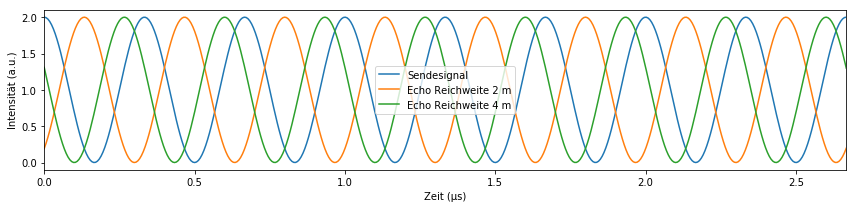

In [2]:
freq = 3*10e6  # modulation frequency in Hz
x_1 = 2 # range in m
x_2 = 4
i_0 = 1 # offset
t_sig = 20e-6 # duration of time signal
c = 3e8 # speed of light
n_samp = 8*4096 # number of sampling point during t_sig

t = np.arange(0,t_sig,t_sig/n_samp)
t_us = np.arange(0,t_sig,t_sig/n_samp)*10e6 # time in µs
sig_0 = np.cos(2*np.pi*freq*t) + i_0 # sender signal
sig_x1 = np.cos(2*np.pi*freq*t - 2*np.pi*freq*2*x_1/c) + i_0 # echo signal range x_1
sig_x2 = np.cos(2*np.pi*freq*t - 2*np.pi*freq*2*x_2/c) + i_0 # echo signal range x_2

fig, ax = plt.subplots(nrows=1, ncols= 1)
ax.set_xlabel('Zeit (µs)')
ax.set_ylabel('Intensität (a.u.)') 
ax.plot(t_us,sig_0,'-',label='Sendesignal')
ax.plot(t_us,sig_x1,'-',label='Echo Reichweite {} m'.format(x_1))
ax.plot(t_us,sig_x2,'-',label='Echo Reichweite {} m'.format(x_2))
ax.set_xlim(left = 0,right = 1/freq * 8 * 10e6) # display 2 periods
ax.legend()
fig.set_size_inches((12,3))
plt.tight_layout() # for lables not to overlap
print('Eindeutigkeitsbereich: {:.2f} m'.format(c/(2*freq)))

Wenn der Phasenversatz $\text{2} \pi$ erreicht hat, dann ist das Ende des sogenannten Eindeutigkeitsbereichs erreicht. In dem  Fall liegt das Echosignal deckungsgleich auf dem Sendesignal.

### Berechnung des Phasenversatzes zwischen Sende- und Echosignal über Signalmultiplikation (Mischen)
Das Sendesignal hat den Intensitätsverlauf $ sig_0(t) = \cos(2\pi f t) + 1 $, das Echolicht 
$ sig_x(t) = \cos(2\pi f t + \phi) + 1 $.
Multipliziert (d.h. *mischt*) man beide Signale, so ergibt sich:
$$ sig_0(t) \cdot sig_x(t) = {1 \over 2} \cos(\phi) + {1 \over 2}\cos(2\pi 2f t - \phi) + \cos(2\pi f t - \phi)
+ \cos(2\pi f t ) + 1$$  
Zur Berechnung der Phase $\phi$ wird der Gleichanteil $mix_{mean}$ des gemischten Signals gemessen. Es gilt: 
$$mix_{mean} = {1 \over 2} \cos(\phi) + 1$$  

Leider ist der Cosinus keine eineindeutige Funktion, weshalb alleine mit der Formel oben nicht der Phasenversatz rekonstruiert werden kann. Dafür benötigt man ein weiteres Mischen mit dem um $-\pi/2$ phasenverschobenen Sendesignal $ sig_{0sin}$. Es gilt:  
$$ sig_{0sin}(t) \cdot sig_x(t) = {1 \over 2} \sin(\phi) + {1 \over 2}\cos(2\pi 2f t - \phi- \pi/2) + \cos(2\pi f t - \phi)
+ \cos(2\pi f t - \pi/2 ) + 1$$  

Zur Berechnung der Phase $\phi$ wird also zusätzlich der Gleichanteil $mix_{meansin}$ des mit dem Sinus-Sendesignal gemischten Echosignals gemessen. Es gilt: 
$$mix_{meansin} = {1 \over 2} \sin(\phi) + 1$$  

Mit etwas Kombinatorik lässt sich aus den beiden Formeln für das DC-Signal der Phasenversatz wie unten gezeigt modulo $2 \pi$ rekonstruieren.

## Numerische Simulation
### Numerische Berechnung des DC-Anteils des Amplitudenspektrums des Mischsignals
In der nachfolgenden Simulation werden für die Reichweiten 0 m, ``X_1`` m und ``x_2`` m das Sendesignal mit dem Echosignal gemischt und daraus das Amplitudenspektrum berechnet und dargestellt.    
Der Wert des Amplitudenspektrums für die Frequenz Null ist nichts Anderes als der Gleichanteil bzw. der Mittelwert des Zeitsignals. Dieser Mittelwert wird zusätzlich in Textform ausgegeben.  
**Im Mittelwert des gemischten Signals steckt also die Phaseninformation.**

0 m: Mittelwert Mischsignal 1.50
2 m: Mittelwert Mischsignal 0.60
4 m: Mittelwert Mischsignal 1.15


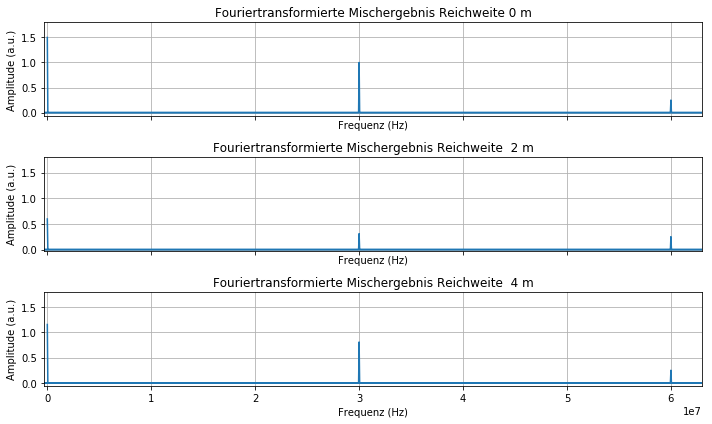

In [3]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols= 1, sharex=True)
f_vals = np.fft.fftfreq(n_samp,t_sig/n_samp)
# =============================================================================
# FFT range 0
# =============================================================================
mix_0 = sig_0 * sig_0
spec_x0 = np.fft.fft(mix_0)/n_samp
ax0.plot(f_vals,np.abs(spec_x0)) # amplitude spectrum
ax0.set_title('Fouriertransformierte Mischergebnis Reichweite 0 m')
ax0.set_ylabel('Amplitude (a.u.)')
ax0.set_xlabel('Frequenz (Hz)')
ax0.set_ylim(ymax=1.8)
ax0.grid()
# =============================================================================
# FFT range x_1
# =============================================================================
mix_1 = sig_x1 * sig_0
spec_x1 = np.fft.fft(mix_1)/n_samp
ax1.plot(f_vals,np.abs(spec_x1)) # amplitude spectrum
ax1.set_title('Fouriertransformierte Mischergebnis Reichweite %2.0f m' % (x_1))
ax1.set_ylabel('Amplitude (a.u.)')
ax1.set_xlabel('Frequenz (Hz)')
ax1.set_ylim(ymax=1.8)
ax1.grid()
# =============================================================================
# FFT range x_2
# =============================================================================
mix_2 = sig_x2 * sig_0
spec_x2 = np.fft.fft(mix_2)/n_samp
ax2.plot(f_vals,np.abs(spec_x2)) # amplitude spectrum
ax2.set_title('Fouriertransformierte Mischergebnis Reichweite %2.0f m' % (x_2))
ax2.set_ylabel('Amplitude (a.u.)')
ax2.set_xlabel('Frequenz (Hz)')
ax2.set_xlim(left = freq*-0.01,right = freq*2.1)
ax2.set_ylim(ymax=1.8)
ax2.grid()
fig.set_size_inches((10,6))
plt.tight_layout()
print('{:.0f} m: Mittelwert Mischsignal {:.2f}'.format(0, np.mean(mix_0)))
print('{:.0f} m: Mittelwert Mischsignal {:.2f}'.format(x_1, np.mean(mix_1)))
print('{:.0f} m: Mittelwert Mischsignal {:.2f}'.format(x_2, np.mean(mix_2)))

Die drei theoretisch vorhergesagten Frequenzanteile bei $0 Hz$, $f$ und $2f$ sind im Amplitudenspektrum jeweils als Peaks gut sichtbar.  
Der Mittelwert und damit der Phasenversatz unterscheidet sich für die drei betrachteten Reichweiten deutlich wie erwartet. Im Folgenden wird simuliert, wie sich der Mittelwert mit zunehmender Reichweite verhält. Damit soll die Eineindeutigkeit zwischen diesem Messwert und der tatsächlichen Reichweite untersucht werden.

### Verlauf DC-Anteil (Mittelwert) Mischsignal bei zunehmender Reichweite und Berechnung des Phasenversatzes daraus
Zuerst werden Echosignale simuliert, die von unterschiedlichen Reichweiten stammen, also jeweils einen anderen Phasenversatz zum Sendesignal haben:

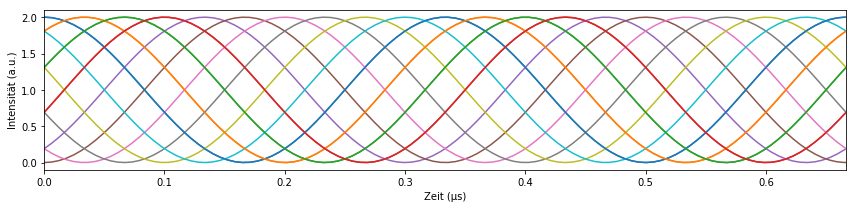

In [4]:
sig_x=[]
range_x=np.arange(0,7,0.5)
for x in range_x:
    sig_x.append(np.cos(2*np.pi*freq*t - 2*np.pi*freq*2*x/c) + i_0)
    
fig, ax = plt.subplots()
ax.set_xlabel('Zeit (µs)')
ax.set_ylabel('Intensität (a.u.)') 
for signal in sig_x:
    ax.plot(t_us,signal)
ax.set_xlim(left = 0,right = 1/freq * 2 * 10e6)
fig.set_size_inches((12,3))
plt.tight_layout()

Jedes dieser Echosignale wird mit dem Sendesignal ``sig_0`` gemischt. Anschließend wird daraus der Mittelwert berechnet und  in Textform ausgegeben. Für jede Reichweite wird dann aus dem jeweiligen Mittelwert eine Phase berechnet und grafisch in Abhängigkeit von der Reichweite dargestellt.

Mittelwert:
1.500 1.405 1.155 0.845 0.595 0.500 0.595 0.845 1.155 1.405 1.500 1.405 1.155 0.845  
Phasenversatz über arccos() berechnet:
-0.000 -0.628 -1.257 -1.885 -2.513 -3.142 -2.513 -1.885 -1.257 -0.628 -0.000 -0.628 -1.257 -1.885 

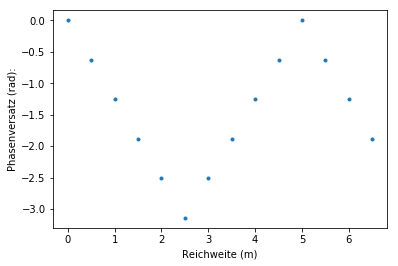

In [5]:
phase_x=[]
print('Mittelwert:')
for signal in sig_x:
    mix = sig_0 * signal
    mix_mean = np.mean(mix)
    print('{:.3f} '.format(mix_mean), end='')
    cos_phi = np.round(2*(mix_mean-i_0),5) # round() needed to avoid cos_phi > 1 or <-1
    phase_x.append(-np.arccos(cos_phi))
print(' ')
print('Phasenversatz über arccos() berechnet:')    
for phase in phase_x:
    print('{:.3f} '.format(phase), end='')
    
fig, ax = plt.subplots()
ax.set_xlabel('Reichweite (m)')
ax.set_ylabel('Phasenversatz (rad):')
ax.plot(range_x,phase_x,'.')

Der Phasenversatz $\phi$ ist grundsätzlich negativ, da das Echosignal im Vergleich zum Sendesignal *verspätet* eintrifft. Eine von Null aus zunehmende Reichweite x bedeutet also einen von Null aus abnehmenden Phasenversatz. Nach dem Phasenversatz $-\pi$ steigt der Wert von $cos(\phi)$ jedoch wieder an. Daher steigt der Mittelwert auch wieder an und erreicht für einen Phasenversatz von $2 \pi$ seinen ursprünglichen Wert.  
Die Cosinusfunktion macht uns also einen Strich durch die Rechnung, wenn aus dem Mittewert des gemischten Signals der Phasenversatz wieder berechnet werden soll.  
Daher steigt in der Mitte des Plots der über den Arcuscosinus berechnete Phasenversatz wieder linear an. Durch das Mischen mit der Sendefrequenz ist also Information verloren gegangen.   

### Zweifaches Mischen zur kompletten Rekonstruktion des Phasenversatzes aus dem Mischsignal
Um den Phasenversatz für den kompletten Bereich von $0...2\pi$ zu rekonstruieren, muss das Echosignal zusätzlich mit dem um $-\pi / 2$ phasenverschobenen Sendesignal gemischt werden. In dem hier vorliegendem Fall ist dies das entsprechende Sinussignal ``sig_0_sin`` zum bisherigen Cosinus-Sendesignal.  
Im nachfolgenden Plot ist der Verlauf des Mittelwertes mit diesen beiden Sendesignalen dargestellt.

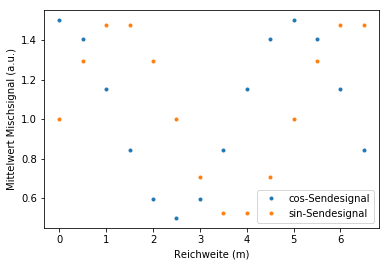

In [6]:
sig_0_sin = np.sin(2*np.pi*freq*t) + i_0 # signal -pi/2 phase shiftet (sine replaces cosine)
mix_mean_x=[]
mix_mean_x_sin=[]
for signal in sig_x:
    mix = sig_0 * signal
    mix_mean = np.mean(mix)
    mix_mean_x.append(mix_mean)
    mix_sin = sig_0_sin * signal
    mix_sin_mean = np.mean(mix_sin)
    mix_mean_x_sin.append(mix_sin_mean)

fig, ax = plt.subplots()
ax.set_xlabel('Reichweite (m)')
ax.set_ylabel('Mittelwert Mischsignal (a.u.)')
ax.plot(range_x,mix_mean_x,'.',label='cos-Sendesignal')
ax.plot(range_x,mix_mean_x_sin,'.',label='sin-Sendesignal')
ax.legend()

Nun lässt sich für jede Reichweite aus den beiden Mittelwerten für die Mischung mit dem cos- und sin-Sendesignal der Phasenversatz rekonstruieren. Je nachdem, ob der Mittelwert des Mischergebnisses mit dem sin-Sendesignal größergleich oder kleiner 1 ist, werden unterschiedliche Formeln zur Berechnung von $\phi$ verwendet. 


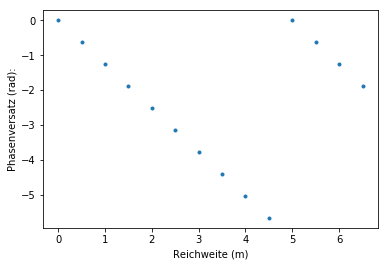

In [7]:
phase_x_full=[]
for index, mean in enumerate(mix_mean_x):
    if mix_mean_x_sin[index]>=0.999999999999: # 0.9... to avoid rounding errors
        cos_phi = np.round(2*(mean-i_0),5)
        phase_x_full.append(-np.arccos(cos_phi))
    else:
        cos_phi = np.round(2*(mean-i_0),5)
        phase_x_full.append(-2*np.pi + np.arccos(cos_phi))

fig, ax = plt.subplots()
ax.set_xlabel('Reichweite (m)')
ax.set_ylabel('Phasenversatz (rad):')
ax.plot(range_x,phase_x_full,'.')

## Erhöhung des Eindeutigkeitsbereichs durch Verwendung von zwei Modulationsfrequenzen
Oben wurde gezeigt, dass aus den beiden Mischergebnissen mit den cos- und sin-Sendesignal der Phasenversatz modulo $2\pi$ wieder rekonstruiert werden kann.  
Verwendet man nun zwei unterschiedliche Modulationsfrequenzen, wobei eine Frequenz nicht ein Vielfaches der anderen sein darf, dann kann der Eindeutigkeitsbereich wesentlich erweitert werden.  
Angenommen, es wird eine zweite Modulationsfreuquen ``freq_2`` verwendet. Im nachfolgendem Plot ist der Verlauf des Phasenversatzes (Modulo $2\pi$) für die beiden Modulationsfrequenzen ``freq`` und ``freq_2`` in Abhängigkeit von der Reichweite dargestellt: 

Eindeutigkeitsbereich nur 3.0 MHz: 5.00 m
Eindeutigkeitsbereich nur 2.5 MHz: 6.00 m


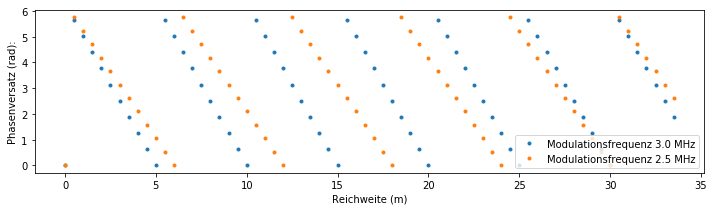

In [8]:
freq_2 = 25*10e5
phase_x_full=[]
phase_x_full_2=[]

range_x=np.arange(0,34,0.5)
for x in range_x:
    phase_x_full.append((-2*np.pi*freq*2*x/c)%(2*np.pi))
    phase_x_full_2.append((-2*np.pi*freq_2*2*x/c)%(2*np.pi))
fig, ax = plt.subplots()
ax.set_xlabel('Reichweite (m)')
ax.set_ylabel('Phasenversatz (rad):')
ax.plot(range_x,phase_x_full,'.',label='Modulationsfrequenz {} MHz'.format(freq/10e6))
ax.plot(range_x,phase_x_full_2,'.',label='Modulationsfrequenz {} MHz'.format(freq_2/10e6))
ax.legend()
fig.set_size_inches((12,3))
print('Eindeutigkeitsbereich nur {} MHz: {:.2f} m'.format(freq/10e6,c/(2*freq)))
print('Eindeutigkeitsbereich nur {} MHz: {:.2f} m'.format(freq_2/10e6,c/(2*freq_2)))

Der "gemeinsame" Eindeutigkeitsbereich entspricht der kleinsten Echolaufzeit, in welche für beide Frequenzen eine komplette Anzahl Perioden passen.  
*Beispiel*: ``freq = 1 MHz`` und ``freq_2 = 0.3 MHz``. 10 µs ist hier die kleinste Zeit: Sie enthält 10 Perioden von ``freq`` und 3 Perioden von ``frequ_2``. 10 µs entsprechen 150 m Lichtlaufzeit hin und zurück. Der "gemeinsame" Eindeutigkeitsbereich für dieses Beispiel beträgt also 150 m.  
Mathematisch entspricht dies dem kleinsten gemeinsamen Vielfachen (kgV) der beiden Perioden. Als Reichweite angegeben, entspricht dies dem kleinsten gemeinsamen Vielfachen der beiden Eindeutigkeitsbereiche. In diesem Beispiel wären dies 15 m bzw. 50 m. Auch über diese Betrachtungsweise ergibt sich wieder der "gemeinsame" Eindeutigkeitsbereich von 150 m.  
   
Wie wählt man nun am besten diese beiden Modulationsfrequenzen aus? Die Antwort hierauf ist gar nicht so einfach. 

*Beispiel:* Die höhere Frequenz wählt man passend zur Auflösung. Ist z.B. eine Auflösung von 5 cm gewünscht und die Phase kann auf 1 % genau bestimmt werden, dann ergibt sich 3 MHz als höhere Modulationsfrequenz.  
Die zweite kleinere Modulationsfrequenz muss so gewählt werden, dass sich deren Phasenversatz für die entsprechenden Reichweiten benachbarter Eindeutigkeitsbereiche (der ersten Modulationsfrequenz, hier z.B. 2 m und 7 m) möglichst klein sind, sich aber noch messbar unterscheiden. 2,99 MHz als zweite Frequenz wäre nicht geeignet, da sich deren Phasenversatz für 2 und 7 m nicht messbar unterscheidet. Bei 2,0 MHz hingegen ist der Unterschied weit größer als die angenommenen 1 % Messunsicherheit. Hier ist z.B. die Kombination von 3 und 2,5 MHz ein guter Kompromiss, die in diesem Beispiel den Eindeutigkeitsbereich der ersten Modulationsfrequenz um den Faktor 6 vergrößert.  

Der nachfolgende Code berechnet den "gemeinsamen" Eindeutigkeitsbereich über das kleinste gemeinsame Vielfache der beiden Einzeleindeutigkeitsbereiche.

In [9]:
unambZone = int(c/(2*freq)*10) # rounding to 0,1 m to avoid non plausible unambiguity zones
unambZone_2 = int(c/(2*freq_2)*10)

def ggT(a, b):
    while b != 0:
        a, b = b, a % b
    return a

def kgV(a,b):
    return(a*b/ggT(a,b))

unambZoneFull = kgV(unambZone,unambZone_2)
print('Gemeinsamer Eindeutigkeitsbereich: {:.1f} m'.format(unambZoneFull/10))

Gemeinsamer Eindeutigkeitsbereich: 30.0 m
